## The Law of Large Numbers
Let $Z_i$ be $N$ independent samples from some probability distribution. According to the *Law of Large numbers*, so long as the expected value $E[Z]$ is finite, the following holds,
$$
\frac{1}{N}\sum_{i=1}^NZ_i\rightarrow E[Z], \,\,\, N\rightarrow\infty.
$$
In words:
> The average of a sequence of random variables from the same distribution converges to the expected value of the distribution.

### Intuition
Consider a random variable $Z$ that can take only two values, $c_1$ and $c_2$. Suppose we have a large number of samples of $Z$, denoting a specific sample $Z_i$. The law says that we can approximate the expected value of $Z$ by averaging over all samples. Consider the average:
$$
\frac{1}{N}\sum_{i=1}^NZ_i
$$
By construction $Z_i$ can only take on $c_1$ or $c_2$, hence we can partition the sum over these two values:
\begin{eqnarray}
    \frac{1}{N}\sum_{i=1}^NZ_i & = & \frac{1}{N}\left(\sum_{Z_i=c_1}c_1 + \sum_{Z_i=c_2}c_2\right) \\
    & = & c_1\sum_{Z_i=c_1} \frac{1}{N} + c_2\sum_{Z_i=c_2}\frac{1}{N}\\
    & = & c_1 \times (\mathrm{approximate\, frequency\, of} \,c_1) \\
        &  & + c_2 \times (\mathrm{approximate\, frequency\,of}\,c_2)\\
    &\approx& c_1\times P(Z=c_1) + c_2\times P(Z=c_2) \\
    & = & E[Z]
\end{eqnarray}
Equality holds in the limit, but we can get closer and closer by using more and more samples in the average. This law holds for almost *any distribution*, minus some important cases we will encounter later.

In [2]:
from default_settings import *
%load_ext autoreload
%autoreload 2

### Example
Below is a diagram of the Law of Large numbers in action for three different sequences of Poisson random variables.

We sample `sample_size = 100000` Poisson random variables with parameter $\lambda = 4.5$. (Recall the expected value of a Poisson random variable is equal to its parameter). We calculate the average for the first $n$ samples, for $n=1$ to `sample_size`.

In [3]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

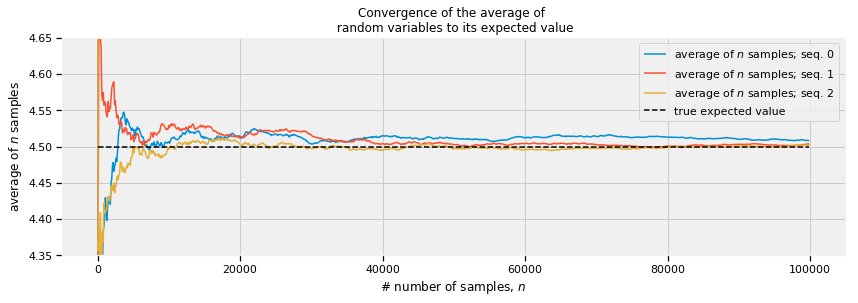

In [6]:
sample_size_ = 100000
expected_value_ = lambda_val_ = 4.5
N_samples = tf.range(start=1, limit=sample_size_, delta=100)
plt.figure(figsize(12.5, 4))
for k in range(3):
    samples = tfd.Poisson(rate=lambda_val_).sample(sample_shape=(sample_size_))
    [ samples_, N_samples_ ] = evaluate([ samples, N_samples])
    
    partial_average_ = [ samples_[:i].mean() for i in N_samples_ ]
    
    plt.plot( N_samples_, partial_average_, lw=1.5, label='average of $n$ samples; seq. %d' %k)
plt.plot(N_samples_, expected_value_*np.ones_like(partial_average_), 
        ls='--', label='true expected value', c='k')
plt.ylim(4.35, 4.65)
plt.title('Convergence of the average of \n random variables to its expected value')
plt.ylabel('average of $n$ samples')
plt.xlabel('# number of samples, $n$')
plt.legend();

#### How quickly am I converging to the expected value?
For a specific $N$, let's do the above trials thousands of times and compute how far away we are from the true expected value, on average. This is simply the law of large numbers again! For example, we are interested in, for a specific $N$, the quantity:
$$
D(N) = \sqrt{\mathbb{E}\left[\left(\frac{1}{N}\sum_{i=1}^N Z_i-4.5\right)^2\right]}
$$
The above formula is interpretable as a distance away from the true value (on average) for some $N$. As the above is an expected value, it can be approximated using the law of large numbers: instead of averaging $Z_i$, we calculate the following multiple times and average them:
$$
Y_k = \left(\frac{1}{N}\sum_{i=1}^NZ_i-4.5\right)^2
$$
By computing the above many $N_y$ times (remember, it is random) and averagint them:
$$
\frac{1}{N_Y}\sum_{k=1}^{N_Y}Y_k\rightarrow \mathbb{E}[Y_k] = \mathbb{E}\left[\left(\frac{1}{N}\sum_{i=1}^NZ_i-4.5\right)^2\right]
$$
Finally, taking the square root:
$$
\sqrt{\frac{1}{N_Y}\sum_{k=1}^{N_Y}Y_k}\approx D(N)
$$

In [7]:
N_Y = tf.constant(250) # Use this many to approximate D(N)
N_array = tf.range(1000., 50000., 2500) # Use this many samples in the approx. to the variance.
D_N_results = tf.zeros(tf.shape(N_array)[0])
lambda_val = tf.constant(4.5)
expected_value = tf.constant(4.5) # for X~Poisson(lambda), E[X]=lambda
[
    N_Y_,
    N_array_,
    D_N_results_,
    expected_value_,
    lambda_val_,
] = evaluate([
    N_Y,
    N_array,
    D_N_results,
    expected_value,
    lambda_val,
])
def D_N(n):
    """This function approx. D_n, the average variance of using n samples."""
    Z = tfd.Poisson(rate=lambda_val_).sample(sample_shape=(int(n), int(N_Y_)))
    average_Z = tf.reduce_mean(Z, axis=0)
    average_Z_ = evaluate(average_Z)
    return np.sqrt(((average_Z_ - expected_value_)**2).mean())

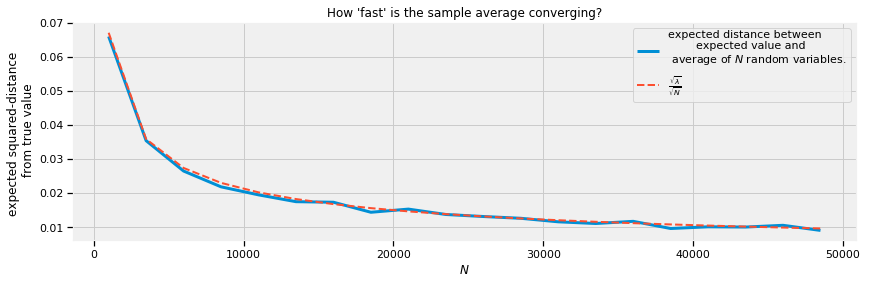

In [10]:
for i, n in enumerate(N_array_):
    D_N_results_[i] = D_N(n)
plt.figure(figsize(12.5, 4))
plt.xlabel('$N$')
plt.ylabel('expected squared-distance \n from true value')
plt.plot(N_array_, D_N_results_, lw=3,
        label='expected distance between\n\
        expected value and \n average of $N$ random variables.')
plt.plot(N_array_, np.sqrt(expected_value_)/np.sqrt(N_array_), lw=2, ls='--',
        label=r'$\frac{\sqrt{\lambda}}{\sqrt{N}}$')
plt.legend()
plt.title("How 'fast' is the sample average converging?");

It turns out we can measure this rate of convergence. In the above figure the function $\sqrt{\lambda}/\sqrt{N}$ was also plotted. This was not chosen arbitrarily. In most cases, given a sequence of random variable distributed like $Z$, the rate of convergence to $E[Z]$ of the law of large numbers is 
$$
\frac{\sqrt{\mathrm{Var}(Z)}}{\sqrt{N}}
$$
This is useful to know: for a given large $N$, we know (on average) how far away we are from the estimate. On the other hand, in a Bayesian setting, this can seem like a useless result: Bayesian analysis is OK with uncertainty so what's the *statistical* point of adding extra precise digits? Though drawing samples can be so computationally cheap that having a *larger* $N$ is fine too.